In [1]:
import numpy as np
import pandas as pd
from dcor import distance_correlation
from autogluon.tabular import TabularDataset, TabularPredictor

In [2]:
train_data = TabularDataset('train.csv')
test_data = TabularDataset('test.csv')

INFER_MISSING = False

In [3]:
def convert_age_to_binary(age):
    if age < 18:
        return 2
    elif age >= 18 and age < 70:
        return 1
    elif age >= 70 and age < 1e6:
        return 0
    else:
        return age

In [4]:
def process_cabin(df):
    if 'Cabin' in df:
        cabins = df.Cabin.str.split('/').to_list()
    
        deck, num, side = [], [], []
        for cabin in cabins:
            if isinstance(cabin, list):
                d, n, s = cabin
            else:
                d, n, s = '', '', ''
            deck.append(d)
            num.append(n)
            side.append(s)
    
        df['deck'] = deck
        df['num'] = num
        df['side'] = side
        
        return df.drop('Cabin', axis=1)

In [5]:
# Train a number of models to predict missing values. We will train the models on the data set which does not have any NAN.
if INFER_MISSING:
    train_data_dropped = train_data.dropna()
    for cx in train_data_dropped:
        if train_data[cx].isna().sum() > 0:
            if train_data_dropped[cx].nunique() <= 5:
                print(f'Infering missing values for feature {cx} as classification')
                tmp = TabularPredictor(label=cx).fit(train_data.dropna(subset=cx).drop('Transported', axis=1), verbosity=1)
    
            elif pd.api.types.is_numeric_dtype(train_data[cx]):
                #print(f'Infering missing values for feature {cx} as regression')
                #tmp = TabularPredictor(label=cx, problem_type='regression').fit(train_data.dropna(subset=cx), verbosity=1)
                print(f'Infering missing values for feature {cx} as setting all to zero')
                train_data[cx].fillna(0.0, inplace=True)
                continue
    
            else:
                print(f'WARNING: Skipping feature {cx}')
                
            train_data.loc[train_data[cx].isna(), cx] = tmp.predict(train_data[train_data[cx].isna()])
            test_data.loc[test_data[cx].isna(), cx] = tmp.predict(test_data[test_data[cx].isna()])

    train_data.to_csv('train_inferred.csv')
    test_data.to_csv('test_inferred.csv')

else:
    # If we are not inferring the missing values, we are doing a few hand-crafted adjustments.

    for d in [train_data, test_data]:

        # 1. Kids are preferred and the elderly getting lower priority:
        d.loc[:, 'Age'] = d.Age.apply(convert_age_to_binary)
    
        # Split the cabins out into deck, room number and side:
        d = process_cabin(d)
    
        # Take the sqrt of some numeric values:
        d.RoomService = np.sqrt(d.RoomService)
        d.FoodCourt = np.sqrt(d.FoodCourt)
        d.ShoppingMall = np.sqrt(d.ShoppingMall)
        d.Spa = np.sqrt(d.Spa)
        d.VRDeck = np.sqrt(d.VRDeck)

    train_data.to_csv('train_manual.csv')
    test_data.to_csv('test_manual.csv')

In [6]:
train_data.isna().mean()

PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
deck            0.000000
num             0.000000
side            0.000000
dtype: float64

<Axes: xlabel='FoodCourt', ylabel='RoomService'>

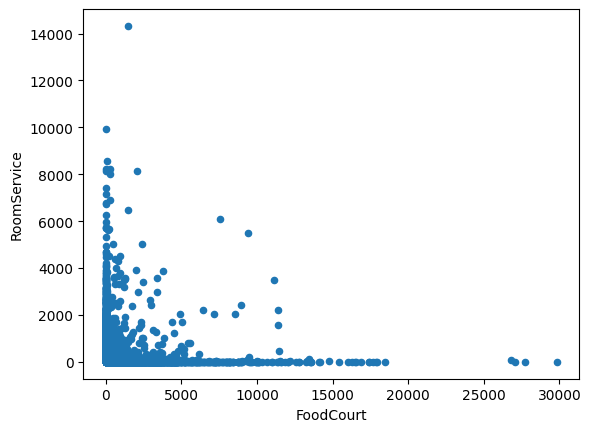

In [7]:
train_data.plot(kind='scatter', x='FoodCourt', y='RoomService')

<Axes: >

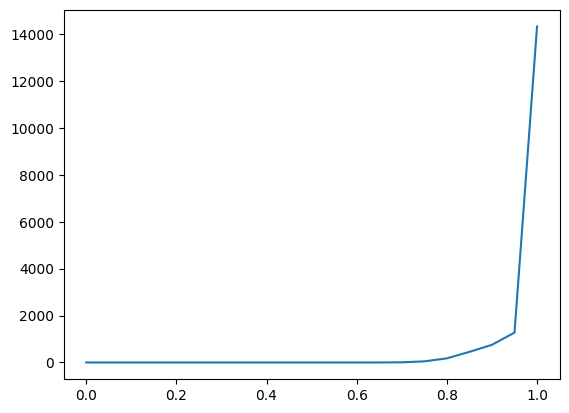

In [8]:
# Add some additional columns, to help models out:
train_data.RoomService.quantile(np.linspace(0, 1.0, 21)).plot()

In [9]:
# Cabins: Whether cabins are multi-booked or single
# Cryo-Sleep: How is correlation with other features? Can I infer something from that?
# All values: Infer the missing values from a model trained on the rest?

In [10]:
predictor = TabularPredictor(label='Transported').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20250122_071535"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #140-Ubuntu SMP Wed Dec 18 17:59:53 UTC 2024
CPU Count:          8
Memory Avail:       17.09 GB / 23.10 GB (74.0%)
Disk Space Avail:   304.41 GB / 937.33 GB (32.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and ben

In [11]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.817241,accuracy,0.071228,41.110707,0.001039,0.138040,2,True,14
1,LightGBM,0.812644,accuracy,0.008211,0.541112,0.008211,0.541112,1,True,4
2,LightGBMLarge,0.810345,accuracy,0.016708,2.156527,0.016708,2.156527,1,True,13
3,LightGBMXT,0.809195,accuracy,0.015691,0.956242,0.015691,0.956242,1,True,3
4,CatBoost,0.800000,accuracy,0.009054,4.695538,0.009054,4.695538,1,True,7
5,XGBoost,0.791954,accuracy,0.023823,1.909090,0.023823,1.909090,1,True,11
6,NeuralNetTorch,0.785057,accuracy,0.022154,27.041913,0.022154,27.041913,1,True,12
7,ExtraTreesEntr,0.783908,accuracy,0.154198,0.754269,0.154198,0.754269,1,True,9
8,ExtraTreesGini,0.780460,accuracy,0.068969,0.713903,0.068969,0.713903,1,True,8
9,RandomForestEntr,0.774713,accuracy,0.071349,1.043252,0.071349,1.043252,1,True,6


In [12]:
predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.817241    accuracy       0.071228  41.110707                0.001039           0.138040            2       True         14
1              LightGBM   0.812644    accuracy       0.008211   0.541112                0.008211           0.541112            1       True          4
2         LightGBMLarge   0.810345    accuracy       0.016708   2.156527                0.016708           2.156527            1       True         13
3            LightGBMXT   0.809195    accuracy       0.015691   0.956242                0.015691           0.956242            1       True          3
4              CatBoost   0.800000    accuracy       0.009054   4.695538                0.009054           4.695538            1       True          7
5               XGBoost   0.7919

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestGini': 'RFModel',
  'RandomForestEntr': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesGini': 'XTModel',
  'ExtraTreesEntr': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.7701149425287356,
  'KNeighborsDist': 0.764367816091954,
  'LightGBMXT': 0.8091954022988506,
  'LightGBM': 0.8126436781609195,
  'RandomForestGini': 0.7724137931034483,
  'RandomForestEntr': 0.774712643678161,
  'CatBoost': 0.8,
  'ExtraTreesGini': 0.7804597701149425,
  'ExtraTreesEntr': 0.7839080459770115,
  'NeuralNetFastAI': 0.7724137931034483,
  'XGBoost': 0.7919540229885057,
  'NeuralNetTorch': 0.7850574712643679,
  'LightGBMLarge': 0.810344827586206

In [13]:
predictor.feature_importance(train_data)

These features in provided data are not utilized by the predictor and will be ignored: ['PassengerId']
Computing feature importance via permutation shuffling for 15 features using 5000 rows with 5 shuffle sets...
	23.74s	= Expected runtime (4.75s per shuffle set)
[3053168:3053168:0100/000000.453318:ERROR:zygote_linux.cc(665)] write: Broken pipe (32)


Wird in einer aktuellen Browsersitzung geöffnet.


	14.68s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
VRDeck,0.08320,0.008226,1.131653e-05,5,0.100137,0.066263
Spa,0.08244,0.002007,4.211775e-08,5,0.086572,0.078308
RoomService,0.07364,0.002958,3.116091e-07,5,0.079730,0.067550
FoodCourt,0.04916,0.005283,1.575918e-05,5,0.060037,0.038283
num,0.03096,0.002794,7.876890e-06,5,0.036713,0.025207
deck,0.02776,0.002256,5.185421e-06,5,0.032404,0.023116
CryoSleep,0.02640,0.002786,1.465781e-05,5,0.032136,0.020664
ShoppingMall,0.02480,0.003418,4.220295e-05,5,0.031837,0.017763
side,0.01328,0.001579,2.351509e-05,5,0.016530,0.010030
HomePlanet,0.01268,0.002194,1.033287e-04,5,0.017197,0.008163


In [14]:
predictor.predict(test_data, model=predictor.model_best).to_frame().join(test_data.PassengerId).set_index('PassengerId').to_csv('submission_autogluon.csv')